## LLM Compressor Workbench -- Getting Started

This notebook will demonstrate how common [LLM Compressor](https://github.com/vllm-project/llm-compressor) flows can be run on the [opendatahub/llmcompressor-workbench](https://quay.io/repository/opendatahub/llmcompressor-workbench) image.

We will show how a user can compress and evaluate a Large Language Model, first without data and then with a calibration dataset.

The notebook will detect if a GPU is available. If one is not available, it will demonstrate an abbreviated run, so users without GPU access can still get a feel for `llm-compressor`.


<div class="alert alert-block alert-info">
<b>Note:</b> If you are not using the Workbench image, just be sure to have lm_eval>=0.4.8 and llmcompressor>=0.5.1 installed
</div>

### 1\) Data-Free Model Compression

In [1]:
import torch
use_gpu = torch.cuda.is_available()

In [2]:
from llmcompressor.modifiers.quantization import QuantizationModifier

# model to compress
model_id = "Qwen/Qwen2.5-7B-Instruct" #"TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# This recipe will quantize all Linear layers except those in the `lm_head`,
#  which is often sensitive to quantization. The W4A16 scheme compresses
#  weights to 4-bit integers while retaining 16-bit activations.
recipe = QuantizationModifier(
    targets="Linear", scheme="W4A16", ignore=["lm_head"]
)

In [3]:
# Load up model using huggingface API
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(
    model_id, device_map="auto", torch_dtype="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
import lm_eval
from lm_eval.utils import make_table

results_baseline = lm_eval.simple_evaluate(
    model="vllm" if use_gpu else "hf",
    model_args={
        "pretrained": model_id,
        "add_bos_token": True,
        "device": "auto"
    },
    tasks=["gsm8k"],
    batch_size="auto" if use_gpu else 4,
    limit=None if use_gpu else 4,
)

INFO 09-13 07:20:17 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 09-13 07:20:18 [__init__.py:239] Automatically detected platform cuda.
INFO 09-13 07:20:28 [config.py:717] This model supports multiple tasks: {'embed', 'classify', 'score', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 09-13 07:20:28 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=8192.


/opt/app-root/lib64/python3.11/site-packages/llmcompressor/pytorch/__init__.py:19: UserWarning: torch.compile is not supported by llmcompressor for torch 2.0.x
  warnings.warn(


WARNING 09-13 07:20:29 [utils.py:2382] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/getting_started/troubleshooting.html#python-multiprocessing for more information. Reason: CUDA is initialized
INFO 09-13 07:20:33 [__init__.py:239] Automatically detected platform cuda.
INFO 09-13 07:20:36 [core.py:58] Initializing a V1 LLM engine (v0.8.5) with config: model='Qwen/Qwen2.5-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='a

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  2.30it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:00,  2.01it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.94it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.97it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.99it/s]



INFO 09-13 07:20:39 [loader.py:458] Loading weights took 2.11 seconds
INFO 09-13 07:20:40 [gpu_model_runner.py:1347] Model loading took 14.2488 GiB and 2.948042 seconds
INFO 09-13 07:20:46 [backends.py:420] Using cache directory: /opt/app-root/src/.cache/vllm/torch_compile_cache/ab94994109/rank_0_0 for vLLM's torch.compile
INFO 09-13 07:20:46 [backends.py:430] Dynamo bytecode transform time: 6.50 s
INFO 09-13 07:20:52 [backends.py:118] Directly load the compiled graph(s) for shape None from the cache, took 5.035 s
INFO 09-13 07:20:53 [monitor.py:33] torch.compile takes 6.50 s in total
INFO 09-13 07:20:54 [kv_cache_utils.py:634] GPU KV cache size: 170,384 tokens
INFO 09-13 07:20:54 [kv_cache_utils.py:637] Maximum concurrency for 32,768 tokens per request: 5.20x
INFO 09-13 07:21:16 [gpu_model_runner.py:1686] Graph capturing finished in 22 secs, took 0.45 GiB
INFO 09-13 07:21:16 [core.py:159] init engine (profile, create kv cache, warmup model) took 36.62 seconds
INFO 09-13 07:21:16 [core

[2025-09-13 07:21:32] INFO task.py:420: Building contexts for gsm8k on rank 0...
100%|██████████| 1319/1319 [00:03<00:00, 356.49it/s]
[2025-09-13 07:21:36] INFO evaluator.py:517: Running generate_until requests
Running generate_until requests:   0%|          | 0/1319 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1319 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Running generate_until requests: 100%|██████████| 1319/1319 [02:48<00:00,  7.82it/s] 
[rank0]:[W913 07:24:28.305679527 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


In [5]:
print(make_table(results_baseline))

|Tasks|Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|
|-----|------:|----------------|-----:|-----------|---|-----:|---|-----:|
|gsm8k|      3|flexible-extract|     5|exact_match|↑  |0.8385|±  |0.0101|
|     |       |strict-match    |     5|exact_match|↑  |0.8089|±  |0.0108|



In [6]:
# Run compression using `oneshot`
from llmcompressor import oneshot

model = oneshot(model=model, recipe=recipe, tokenizer=tokenizer)

2025-09-13T07:24:29.943238+0000 | reset | INFO - Compression lifecycle reset


Logging all LLM Compressor modifier-level logs to sparse_logs/13-09-2025_07.24.29.log
[2025-09-13 07:24:29] INFO logger.py:391: Logging all LLM Compressor modifier-level logs to sparse_logs/13-09-2025_07.24.29.log


2025-09-13T07:24:29.946181+0000 | from_modifiers | INFO - Creating recipe from modifiers


manager stage: Modifiers initialized


2025-09-13T07:24:32.686849+0000 | initialize | INFO - Compression lifecycle initialized for 1 modifiers


manager stage: Modifiers finalized


2025-09-13T07:24:32.688037+0000 | finalize | INFO - Compression lifecycle finalized for 1 modifiers
2025-09-13T07:24:32.688517+0000 | post_process | WARNING - Optimized model is not saved. To save, please provide`output_dir` as input arg.Ex. `oneshot(..., output_dir=...)`


In [7]:
# Save model and tokenizer
model_dir = "./" + model_id.split("/")[-1] + "-W4A16"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir);

2025-09-13T07:24:32.692386+0000 | save_pretrained_wrapper | INFO - Fetching state_dict - this may take some time
2025-09-13T07:24:51.999153+0000 | save_pretrained_wrapper | INFO - Fetching compressor
2025-09-13T07:24:51.999899+0000 | get_model_compressor | INFO - skip_sparsity_compression_stats set to True. Skipping sparsity compression statistic calculations. No sparsity compressor will be applied.


Quantized Compression: 100%|██████████| 731/731 [00:42<00:00, 17.40it/s]

2025-09-13T07:25:34.013183+0000 | save_pretrained_wrapper | INFO - Saving compressed model to disk


### 2\) Evaluate compressed model using open-source `lm_eval` framework

We will evaluate the performance of the model on the [`wikitext`](https://paperswithcode.com/dataset/wikitext-2) language modeling dataset

In [8]:
import lm_eval
from lm_eval.utils import make_table

results_w4a16 = lm_eval.simple_evaluate(
    model="vllm" if use_gpu else "hf",
    model_args={
        "pretrained": model_dir,
        "add_bos_token": True,
        "device": "auto"
    },
    tasks=["gsm8k"],
    batch_size="auto" if use_gpu else 4,
    limit=None if use_gpu else 4,
)

[2025-09-13 07:26:03] INFO evaluator.py:169: Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
[2025-09-13 07:26:03] INFO evaluator.py:193: Initializing vllm model, with arguments: {'pretrained': './Qwen2.5-7B-Instruct-W4A16', 'add_bos_token': True, 'device': 'auto'}


INFO 09-13 07:26:03 [config.py:717] This model supports multiple tasks: {'embed', 'classify', 'score', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 09-13 07:26:03 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=8192.


/opt/app-root/lib64/python3.11/site-packages/llmcompressor/pytorch/__init__.py:19: UserWarning: torch.compile is not supported by llmcompressor for torch 2.0.x
  warnings.warn(


INFO 09-13 07:26:07 [__init__.py:239] Automatically detected platform cuda.
INFO 09-13 07:26:10 [core.py:58] Initializing a V1 LLM engine (v0.8.5) with config: model='./Qwen2.5-7B-Instruct-W4A16', speculative_config=None, tokenizer='./Qwen2.5-7B-Instruct-W4A16', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=compressed-tensors, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=1234, served_model_name=./Qwen2.5-7B-Instruct-W4A16, num_scheduler_ste

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  7.26it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.28it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.54it/s]



INFO 09-13 07:26:11 [loader.py:458] Loading weights took 0.91 seconds
WARNING 09-13 07:26:12 [kv_cache.py:128] Using Q scale 1.0 and prob scale 1.0 with fp8 attention. This may cause accuracy issues. Please make sure Q/prob scaling factors are available in the fp8 checkpoint.
INFO 09-13 07:26:12 [gpu_model_runner.py:1347] Model loading took 5.1816 GiB and 1.158507 seconds
INFO 09-13 07:26:20 [backends.py:420] Using cache directory: /opt/app-root/src/.cache/vllm/torch_compile_cache/9b199998ee/rank_0_0 for vLLM's torch.compile
INFO 09-13 07:26:20 [backends.py:430] Dynamo bytecode transform time: 8.46 s
INFO 09-13 07:26:23 [backends.py:136] Cache the graph of shape None for later use
INFO 09-13 07:26:52 [backends.py:148] Compiling a graph for general shape takes 30.98 s
INFO 09-13 07:27:07 [monitor.py:33] torch.compile takes 39.44 s in total
INFO 09-13 07:27:08 [kv_cache_utils.py:634] GPU KV cache size: 332,352 tokens
INFO 09-13 07:27:08 [kv_cache_utils.py:637] Maximum concurrency for 32,

[2025-09-13 07:27:52] INFO task.py:420: Building contexts for gsm8k on rank 0...
100%|██████████| 1319/1319 [00:03<00:00, 346.91it/s]
[2025-09-13 07:27:56] INFO evaluator.py:517: Running generate_until requests
Running generate_until requests:   0%|          | 0/1319 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1319 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Running generate_until requests: 100%|██████████| 1319/1319 [03:18<00:00,  6.64it/s] 
[rank0]:[W913 07:31:19.830507743 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


In [9]:
print(make_table(results_w4a16))

|Tasks|Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|
|-----|------:|----------------|-----:|-----------|---|-----:|---|-----:|
|gsm8k|      3|flexible-extract|     5|exact_match|↑  |0.8279|±  |0.0104|
|     |       |strict-match    |     5|exact_match|↑  |0.8059|±  |0.0109|



### 3\) Calibrated Compression with a Dataset

Some more advanced compression algorithms require a small dataset of calibration samples that are meant to be a representative random subset of the language the model will see at inference.

We will show how the previous section can be augmented with a calibration dataset and GPTQ, one of the first published LLM compression algorithms.

<div class="alert alert-block alert-info">
<b>Note:</b> This will take several minutes if no GPU is available
</div>

In [10]:
# We will use a new recipe running GPTQ (https://arxiv.org/abs/2210.17323)
# to reduce error caused by quantization. GPTQ requires a calibration dataset.
from llmcompressor.modifiers.quantization import GPTQModifier

recipe = GPTQModifier(targets="Linear", scheme="W4A16", ignore=["lm_head"])

In [11]:
from datasets import load_dataset

# Create the calibration dataset, using Huggingface datasets API
dataset_id = "HuggingFaceH4/ultrachat_200k"

# Select number of samples. 512 samples is a good place to start.
# Increasing the number of samples can improve accuracy.
num_calibration_samples = 512 if use_gpu else 4
max_sequence_length = 2048 if use_gpu else 16

# Load dataset
ds = load_dataset(dataset_id, split="train_sft")
# Shuffle and grab only the number of samples we need
ds = ds.shuffle(seed=42).select(range(num_calibration_samples))

# Preprocess and tokenize into format the model uses
def preprocess(example):
    text = tokenizer.apply_chat_template(
            example["messages"],
            tokenize=False,
        )
    return tokenizer(
        text,
        padding=False,
        max_length=max_sequence_length,
        truncation=True,
        add_special_tokens=False,
    )

ds = ds.map(preprocess, remove_columns=ds.column_names)

Map:   0%|          | 0/512 [00:00<?, ? examples/s]

In [12]:
# oneshot modifies model in-place, so reload
model = AutoModelForCausalLM.from_pretrained(
    model_id, device_map="auto", torch_dtype="auto"
)
# run oneshot again, with dataset
model = oneshot(
    model=model,
    dataset=ds,
    recipe=recipe,
    max_seq_length=max_sequence_length,
    num_calibration_samples=num_calibration_samples,
)

[2025-09-13 07:31:35] INFO modeling.py:990: We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-09-13T07:33:05.911454+0000 | reset | INFO - Compression lifecycle reset
2025-09-13T07:33:05.912581+0000 | from_modifiers | INFO - Creating recipe from modifiers
2025-09-13T07:33:05.914388+0000 | _check_build_quant_modifier | WARNING - GPTQ quantization is set to True without an active quantization modifier.
2025-09-13T07:33:05.915037+0000 | _build_quant_modifier | INFO - Building quantization modifier with args: {'targets': 'Linear', 'scheme': 'W4A16', 'ignore': ['lm_head']}
2025-09-13T07:33:05.948516+0000 | _check_calibration_data | INFO - Skipping QuantizationModifier calibration, it is not required for the provided quantization config.


(1/29): Calibrating: 100%|██████████| 512/512 [00:19<00:00, 25.89it/s]

2025-09-13T07:33:29.042890+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.0.self_attn.q_proj using 512 samples


2025-09-13T07:33:30.599837+0000 | compress | METRIC - time 1.56s
2025-09-13T07:33:30.600729+0000 | compress | METRIC - error 1758.89
2025-09-13T07:33:30.601588+0000 | compress | METRIC - GPU 0 | usage: 77.73% | total memory: 48 GB
2025-09-13T07:33:30.601931+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:33:30.602581+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.0.self_attn.k_proj using 512 samples
2025-09-13T07:33:32.035045+0000 | compress | METRIC - time 1.43s
2025-09-13T07:33:32.035692+0000 | compress | METRIC - error 394.13
2025-09-13T07:33:32.036394+0000 | compress | METRIC - GPU 0 | usage: 77.73% | total memory: 48 GB
2025-09-13T07:33:32.036869+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:33:32.037452+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.0.self_attn.v_proj using 512 samples
2025-09-13T07:33:33.473278+0000 | compress | METRIC - time 1.44s
2025-09-13T07:33:33.474256+0000 | com

(2/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.29it/s]

2025-09-13T07:34:09.976152+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.1.self_attn.q_proj using 512 samples


2025-09-13T07:34:11.482307+0000 | compress | METRIC - time 1.51s
2025-09-13T07:34:11.483362+0000 | compress | METRIC - error 760.12
2025-09-13T07:34:11.484015+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:34:11.484399+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:34:11.485051+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.1.self_attn.k_proj using 512 samples
2025-09-13T07:34:12.902744+0000 | compress | METRIC - time 1.42s
2025-09-13T07:34:12.903758+0000 | compress | METRIC - error 196.17
2025-09-13T07:34:12.904505+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:34:12.904862+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:34:12.905558+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.1.self_attn.v_proj using 512 samples
2025-09-13T07:34:14.339826+0000 | compress | METRIC - time 1.43s
2025-09-13T07:34:14.340830+0000 | comp

(3/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.29it/s]

2025-09-13T07:34:50.601019+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.2.self_attn.q_proj using 512 samples


2025-09-13T07:34:52.123176+0000 | compress | METRIC - time 1.52s
2025-09-13T07:34:52.124193+0000 | compress | METRIC - error 3996.47
2025-09-13T07:34:52.125090+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:34:52.125584+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:34:52.126530+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.2.self_attn.k_proj using 512 samples
2025-09-13T07:34:53.564187+0000 | compress | METRIC - time 1.44s
2025-09-13T07:34:53.565230+0000 | compress | METRIC - error 1063.97
2025-09-13T07:34:53.566130+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:34:53.566618+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:34:53.567550+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.2.self_attn.v_proj using 512 samples
2025-09-13T07:34:55.002011+0000 | compress | METRIC - time 1.43s
2025-09-13T07:34:55.003086+0000 | co

(4/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.52it/s]

2025-09-13T07:35:31.116729+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.3.self_attn.q_proj using 512 samples


2025-09-13T07:35:32.631376+0000 | compress | METRIC - time 1.51s
2025-09-13T07:35:32.632379+0000 | compress | METRIC - error 4646.26
2025-09-13T07:35:32.632903+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:35:32.633347+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:35:32.634406+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.3.self_attn.k_proj using 512 samples
2025-09-13T07:35:34.068636+0000 | compress | METRIC - time 1.43s
2025-09-13T07:35:34.069626+0000 | compress | METRIC - error 1153.94
2025-09-13T07:35:34.070251+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:35:34.070643+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:35:34.071274+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.3.self_attn.v_proj using 512 samples
2025-09-13T07:35:35.524423+0000 | compress | METRIC - time 1.45s
2025-09-13T07:35:35.525477+0000 | co

(5/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.41it/s]

2025-09-13T07:36:11.632812+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.4.self_attn.q_proj using 512 samples


2025-09-13T07:36:13.125153+0000 | compress | METRIC - time 1.49s
2025-09-13T07:36:13.125830+0000 | compress | METRIC - error 11601.06
2025-09-13T07:36:13.126463+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:36:13.126843+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:36:13.127539+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.4.self_attn.k_proj using 512 samples
2025-09-13T07:36:14.551394+0000 | compress | METRIC - time 1.42s
2025-09-13T07:36:14.552398+0000 | compress | METRIC - error 2534.04
2025-09-13T07:36:14.552911+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:36:14.553231+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:36:14.554007+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.4.self_attn.v_proj using 512 samples
2025-09-13T07:36:16.000370+0000 | compress | METRIC - time 1.45s
2025-09-13T07:36:16.001323+0000 | c

(6/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.01it/s]

2025-09-13T07:36:52.430094+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.5.self_attn.q_proj using 512 samples


2025-09-13T07:36:53.926526+0000 | compress | METRIC - time 1.50s
2025-09-13T07:36:53.927652+0000 | compress | METRIC - error 10932.83
2025-09-13T07:36:53.928249+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:36:53.928608+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:36:53.929252+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.5.self_attn.k_proj using 512 samples
2025-09-13T07:36:55.362874+0000 | compress | METRIC - time 1.43s
2025-09-13T07:36:55.363947+0000 | compress | METRIC - error 2225.24
2025-09-13T07:36:55.364547+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:36:55.365066+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:36:55.365667+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.5.self_attn.v_proj using 512 samples
2025-09-13T07:36:56.770701+0000 | compress | METRIC - time 1.40s
2025-09-13T07:36:56.771720+0000 | c

(7/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.43it/s]

2025-09-13T07:37:32.833428+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.6.self_attn.q_proj using 512 samples


2025-09-13T07:37:34.333211+0000 | compress | METRIC - time 1.50s
2025-09-13T07:37:34.334167+0000 | compress | METRIC - error 7173.37
2025-09-13T07:37:34.334795+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:37:34.335178+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:37:34.335863+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.6.self_attn.k_proj using 512 samples
2025-09-13T07:37:35.786677+0000 | compress | METRIC - time 1.45s
2025-09-13T07:37:35.787612+0000 | compress | METRIC - error 1422.52
2025-09-13T07:37:35.788209+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:37:35.788611+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:37:35.789308+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.6.self_attn.v_proj using 512 samples
2025-09-13T07:37:37.268772+0000 | compress | METRIC - time 1.48s
2025-09-13T07:37:37.269885+0000 | co

(8/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.60it/s]

2025-09-13T07:38:12.935963+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.7.self_attn.q_proj using 512 samples


2025-09-13T07:38:14.408414+0000 | compress | METRIC - time 1.47s
2025-09-13T07:38:14.409438+0000 | compress | METRIC - error 8648.19
2025-09-13T07:38:14.410129+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:38:14.410527+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:38:14.411273+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.7.self_attn.k_proj using 512 samples
2025-09-13T07:38:15.799877+0000 | compress | METRIC - time 1.39s
2025-09-13T07:38:15.800937+0000 | compress | METRIC - error 1481.31
2025-09-13T07:38:15.801652+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:38:15.802031+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:38:15.802751+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.7.self_attn.v_proj using 512 samples
2025-09-13T07:38:17.228488+0000 | compress | METRIC - time 1.43s
2025-09-13T07:38:17.229561+0000 | co

(9/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.54it/s]

2025-09-13T07:38:52.921523+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.8.self_attn.q_proj using 512 samples


2025-09-13T07:38:54.422133+0000 | compress | METRIC - time 1.50s
2025-09-13T07:38:54.423113+0000 | compress | METRIC - error 12965.93
2025-09-13T07:38:54.423792+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:38:54.424134+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:38:54.424880+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.8.self_attn.k_proj using 512 samples
2025-09-13T07:38:55.865019+0000 | compress | METRIC - time 1.44s
2025-09-13T07:38:55.866060+0000 | compress | METRIC - error 2899.59
2025-09-13T07:38:55.866736+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:38:55.867160+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:38:55.867864+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.8.self_attn.v_proj using 512 samples
2025-09-13T07:38:57.343952+0000 | compress | METRIC - time 1.48s
2025-09-13T07:38:57.345030+0000 | c

(10/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.55it/s]

2025-09-13T07:39:33.292836+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.9.self_attn.q_proj using 512 samples


2025-09-13T07:39:34.861383+0000 | compress | METRIC - time 1.57s
2025-09-13T07:39:34.862495+0000 | compress | METRIC - error 11290.35
2025-09-13T07:39:34.863109+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:39:34.863643+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:39:34.864322+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.9.self_attn.k_proj using 512 samples
2025-09-13T07:39:36.317787+0000 | compress | METRIC - time 1.45s
2025-09-13T07:39:36.318831+0000 | compress | METRIC - error 1992.41
2025-09-13T07:39:36.319520+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:39:36.319915+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:39:36.320657+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.9.self_attn.v_proj using 512 samples
2025-09-13T07:39:37.767665+0000 | compress | METRIC - time 1.45s
2025-09-13T07:39:37.768695+0000 | c

(11/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.29it/s]

2025-09-13T07:40:13.965006+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.10.self_attn.q_proj using 512 samples


2025-09-13T07:40:15.426145+0000 | compress | METRIC - time 1.46s
2025-09-13T07:40:15.427105+0000 | compress | METRIC - error 9752.68
2025-09-13T07:40:15.427874+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:40:15.428201+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:40:15.428836+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.10.self_attn.k_proj using 512 samples
2025-09-13T07:40:16.825583+0000 | compress | METRIC - time 1.40s
2025-09-13T07:40:16.826666+0000 | compress | METRIC - error 1867.76
2025-09-13T07:40:16.827473+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:40:16.828021+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:40:16.828684+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.10.self_attn.v_proj using 512 samples
2025-09-13T07:40:18.212101+0000 | compress | METRIC - time 1.38s
2025-09-13T07:40:18.213043+0000 | 

(12/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 24.90it/s]

2025-09-13T07:40:54.518717+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.11.self_attn.q_proj using 512 samples


2025-09-13T07:40:56.035228+0000 | compress | METRIC - time 1.52s
2025-09-13T07:40:56.036437+0000 | compress | METRIC - error 11233.37
2025-09-13T07:40:56.037117+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:40:56.037573+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:40:56.038262+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.11.self_attn.k_proj using 512 samples
2025-09-13T07:40:57.470100+0000 | compress | METRIC - time 1.43s
2025-09-13T07:40:57.471158+0000 | compress | METRIC - error 2421.30
2025-09-13T07:40:57.471862+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:40:57.472347+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:40:57.472910+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.11.self_attn.v_proj using 512 samples
2025-09-13T07:40:58.900218+0000 | compress | METRIC - time 1.43s
2025-09-13T07:40:58.901301+0000 |

(13/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 24.88it/s]

2025-09-13T07:41:35.561543+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.12.self_attn.q_proj using 512 samples


2025-09-13T07:41:37.060499+0000 | compress | METRIC - time 1.50s
2025-09-13T07:41:37.061507+0000 | compress | METRIC - error 11869.59
2025-09-13T07:41:37.062246+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:41:37.062819+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:41:37.063526+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.12.self_attn.k_proj using 512 samples
2025-09-13T07:41:38.508928+0000 | compress | METRIC - time 1.45s
2025-09-13T07:41:38.509874+0000 | compress | METRIC - error 2524.18
2025-09-13T07:41:38.510620+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:41:38.511005+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:41:38.511857+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.12.self_attn.v_proj using 512 samples
2025-09-13T07:41:39.970132+0000 | compress | METRIC - time 1.46s
2025-09-13T07:41:39.971202+0000 |

(14/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 24.94it/s]

2025-09-13T07:42:16.512225+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.13.self_attn.q_proj using 512 samples


2025-09-13T07:42:18.014267+0000 | compress | METRIC - time 1.50s
2025-09-13T07:42:18.015301+0000 | compress | METRIC - error 12226.42
2025-09-13T07:42:18.015975+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:42:18.016409+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:42:18.017228+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.13.self_attn.k_proj using 512 samples
2025-09-13T07:42:19.450676+0000 | compress | METRIC - time 1.43s
2025-09-13T07:42:19.451791+0000 | compress | METRIC - error 2274.22
2025-09-13T07:42:19.452462+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:42:19.452933+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:42:19.453903+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.13.self_attn.v_proj using 512 samples
2025-09-13T07:42:20.884351+0000 | compress | METRIC - time 1.43s
2025-09-13T07:42:20.885478+0000 |

(15/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.29it/s]

2025-09-13T07:42:56.869435+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.14.self_attn.q_proj using 512 samples


2025-09-13T07:42:58.343155+0000 | compress | METRIC - time 1.47s
2025-09-13T07:42:58.344219+0000 | compress | METRIC - error 17300.34
2025-09-13T07:42:58.344857+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:42:58.345209+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:42:58.345860+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.14.self_attn.k_proj using 512 samples
2025-09-13T07:42:59.789548+0000 | compress | METRIC - time 1.44s
2025-09-13T07:42:59.790623+0000 | compress | METRIC - error 3375.02
2025-09-13T07:42:59.791234+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:42:59.791598+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:42:59.792285+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.14.self_attn.v_proj using 512 samples
2025-09-13T07:43:01.225540+0000 | compress | METRIC - time 1.43s
2025-09-13T07:43:01.226693+0000 |

(16/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.49it/s]

2025-09-13T07:43:37.435985+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.15.self_attn.q_proj using 512 samples


2025-09-13T07:43:38.916368+0000 | compress | METRIC - time 1.48s
2025-09-13T07:43:38.917399+0000 | compress | METRIC - error 12707.10
2025-09-13T07:43:38.918198+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:43:38.918675+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:43:38.919610+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.15.self_attn.k_proj using 512 samples
2025-09-13T07:43:40.360209+0000 | compress | METRIC - time 1.44s
2025-09-13T07:43:40.361227+0000 | compress | METRIC - error 2774.93
2025-09-13T07:43:40.362062+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:43:40.362519+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:43:40.363475+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.15.self_attn.v_proj using 512 samples
2025-09-13T07:43:41.817873+0000 | compress | METRIC - time 1.45s
2025-09-13T07:43:41.818918+0000 |

(17/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.27it/s]

2025-09-13T07:44:18.069192+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.16.self_attn.q_proj using 512 samples


2025-09-13T07:44:19.606971+0000 | compress | METRIC - time 1.54s
2025-09-13T07:44:19.607978+0000 | compress | METRIC - error 13904.45
2025-09-13T07:44:19.608672+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:44:19.609017+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:44:19.609735+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.16.self_attn.k_proj using 512 samples
2025-09-13T07:44:21.037566+0000 | compress | METRIC - time 1.43s
2025-09-13T07:44:21.038635+0000 | compress | METRIC - error 2701.95
2025-09-13T07:44:21.039263+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:44:21.039625+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:44:21.040324+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.16.self_attn.v_proj using 512 samples
2025-09-13T07:44:22.459677+0000 | compress | METRIC - time 1.42s
2025-09-13T07:44:22.460679+0000 |

(18/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 24.92it/s]

2025-09-13T07:44:59.137060+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.17.self_attn.q_proj using 512 samples


2025-09-13T07:45:00.654415+0000 | compress | METRIC - time 1.52s
2025-09-13T07:45:00.655429+0000 | compress | METRIC - error 15815.09
2025-09-13T07:45:00.656158+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:45:00.656549+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:45:00.657221+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.17.self_attn.k_proj using 512 samples
2025-09-13T07:45:02.119753+0000 | compress | METRIC - time 1.46s
2025-09-13T07:45:02.120821+0000 | compress | METRIC - error 2704.02
2025-09-13T07:45:02.121618+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:45:02.122051+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:45:02.122758+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.17.self_attn.v_proj using 512 samples
2025-09-13T07:45:03.580749+0000 | compress | METRIC - time 1.46s
2025-09-13T07:45:03.581872+0000 |

(19/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.44it/s]

2025-09-13T07:45:39.600541+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.18.self_attn.q_proj using 512 samples


2025-09-13T07:45:41.117193+0000 | compress | METRIC - time 1.52s
2025-09-13T07:45:41.117846+0000 | compress | METRIC - error 12440.67
2025-09-13T07:45:41.118564+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:45:41.118929+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:45:41.119649+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.18.self_attn.k_proj using 512 samples
2025-09-13T07:45:42.575902+0000 | compress | METRIC - time 1.46s
2025-09-13T07:45:42.576917+0000 | compress | METRIC - error 2127.24
2025-09-13T07:45:42.577701+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:45:42.578324+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:45:42.579088+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.18.self_attn.v_proj using 512 samples
2025-09-13T07:45:44.040511+0000 | compress | METRIC - time 1.46s
2025-09-13T07:45:44.041586+0000 |

(20/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.30it/s]

2025-09-13T07:46:20.338170+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.19.self_attn.q_proj using 512 samples


2025-09-13T07:46:21.816723+0000 | compress | METRIC - time 1.48s
2025-09-13T07:46:21.817784+0000 | compress | METRIC - error 16129.55
2025-09-13T07:46:21.818676+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:46:21.819082+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:46:21.820011+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.19.self_attn.k_proj using 512 samples
2025-09-13T07:46:23.234268+0000 | compress | METRIC - time 1.41s
2025-09-13T07:46:23.235253+0000 | compress | METRIC - error 2512.22
2025-09-13T07:46:23.236033+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:46:23.236501+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:46:23.237382+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.19.self_attn.v_proj using 512 samples
2025-09-13T07:46:24.644565+0000 | compress | METRIC - time 1.41s
2025-09-13T07:46:24.645592+0000 |

(21/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 24.89it/s]

2025-09-13T07:47:01.209991+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.20.self_attn.q_proj using 512 samples


2025-09-13T07:47:02.724048+0000 | compress | METRIC - time 1.51s
2025-09-13T07:47:02.725069+0000 | compress | METRIC - error 14406.10
2025-09-13T07:47:02.725688+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:47:02.726151+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:47:02.726738+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.20.self_attn.k_proj using 512 samples
2025-09-13T07:47:04.147440+0000 | compress | METRIC - time 1.42s
2025-09-13T07:47:04.148471+0000 | compress | METRIC - error 2370.37
2025-09-13T07:47:04.149234+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:47:04.149702+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:47:04.150589+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.20.self_attn.v_proj using 512 samples
2025-09-13T07:47:05.572240+0000 | compress | METRIC - time 1.42s
2025-09-13T07:47:05.573292+0000 |

(22/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.40it/s]

2025-09-13T07:47:41.680697+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.21.self_attn.q_proj using 512 samples


2025-09-13T07:47:43.200598+0000 | compress | METRIC - time 1.52s
2025-09-13T07:47:43.201659+0000 | compress | METRIC - error 18253.88
2025-09-13T07:47:43.202277+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:47:43.202680+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:47:43.203495+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.21.self_attn.k_proj using 512 samples
2025-09-13T07:47:44.655408+0000 | compress | METRIC - time 1.45s
2025-09-13T07:47:44.656448+0000 | compress | METRIC - error 2607.52
2025-09-13T07:47:44.656996+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:47:44.657322+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:47:44.658206+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.21.self_attn.v_proj using 512 samples
2025-09-13T07:47:46.118789+0000 | compress | METRIC - time 1.46s
2025-09-13T07:47:46.119465+0000 |

(23/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.34it/s]

2025-09-13T07:48:22.391629+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.22.self_attn.q_proj using 512 samples


2025-09-13T07:48:23.934766+0000 | compress | METRIC - time 1.54s
2025-09-13T07:48:23.935728+0000 | compress | METRIC - error 25928.19
2025-09-13T07:48:23.936531+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:48:23.937083+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:48:23.937752+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.22.self_attn.k_proj using 512 samples
2025-09-13T07:48:25.399822+0000 | compress | METRIC - time 1.46s
2025-09-13T07:48:25.400815+0000 | compress | METRIC - error 3442.48
2025-09-13T07:48:25.401412+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:48:25.401782+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:48:25.402798+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.22.self_attn.v_proj using 512 samples
2025-09-13T07:48:26.866121+0000 | compress | METRIC - time 1.46s
2025-09-13T07:48:26.867116+0000 |

(24/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.09it/s]

2025-09-13T07:49:03.370124+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.23.self_attn.q_proj using 512 samples


2025-09-13T07:49:04.880510+0000 | compress | METRIC - time 1.51s
2025-09-13T07:49:04.881564+0000 | compress | METRIC - error 29589.67
2025-09-13T07:49:04.882324+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:49:04.882841+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:49:04.883431+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.23.self_attn.k_proj using 512 samples
2025-09-13T07:49:06.305571+0000 | compress | METRIC - time 1.42s
2025-09-13T07:49:06.306648+0000 | compress | METRIC - error 4241.69
2025-09-13T07:49:06.307195+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:49:06.307680+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:49:06.308566+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.23.self_attn.v_proj using 512 samples
2025-09-13T07:49:07.757461+0000 | compress | METRIC - time 1.45s
2025-09-13T07:49:07.758508+0000 |

(25/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.09it/s]

2025-09-13T07:49:44.257003+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.24.self_attn.q_proj using 512 samples


2025-09-13T07:49:45.786649+0000 | compress | METRIC - time 1.53s
2025-09-13T07:49:45.787592+0000 | compress | METRIC - error 26418.90
2025-09-13T07:49:45.788291+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:49:45.788676+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:49:45.789443+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.24.self_attn.k_proj using 512 samples
2025-09-13T07:49:47.238049+0000 | compress | METRIC - time 1.45s
2025-09-13T07:49:47.239103+0000 | compress | METRIC - error 3574.71
2025-09-13T07:49:47.239778+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:49:47.240160+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:49:47.240876+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.24.self_attn.v_proj using 512 samples
2025-09-13T07:49:48.653498+0000 | compress | METRIC - time 1.41s
2025-09-13T07:49:48.654482+0000 |

(26/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.24it/s]

2025-09-13T07:50:24.901602+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.25.self_attn.q_proj using 512 samples


2025-09-13T07:50:26.431280+0000 | compress | METRIC - time 1.53s
2025-09-13T07:50:26.432287+0000 | compress | METRIC - error 27929.86
2025-09-13T07:50:26.433079+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:50:26.433487+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:50:26.434285+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.25.self_attn.k_proj using 512 samples
2025-09-13T07:50:27.893432+0000 | compress | METRIC - time 1.46s
2025-09-13T07:50:27.894443+0000 | compress | METRIC - error 3455.37
2025-09-13T07:50:27.895181+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:50:27.895760+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:50:27.896409+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.25.self_attn.v_proj using 512 samples
2025-09-13T07:50:29.361826+0000 | compress | METRIC - time 1.47s
2025-09-13T07:50:29.362880+0000 |

(27/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 24.93it/s]

2025-09-13T07:51:05.946176+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.26.self_attn.q_proj using 512 samples


2025-09-13T07:51:07.483944+0000 | compress | METRIC - time 1.54s
2025-09-13T07:51:07.485062+0000 | compress | METRIC - error 35148.51
2025-09-13T07:51:07.485890+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:51:07.486292+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:51:07.487028+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.26.self_attn.k_proj using 512 samples
2025-09-13T07:51:08.910827+0000 | compress | METRIC - time 1.42s
2025-09-13T07:51:08.911780+0000 | compress | METRIC - error 4350.17
2025-09-13T07:51:08.912463+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:51:08.912959+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:51:08.913555+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.26.self_attn.v_proj using 512 samples
2025-09-13T07:51:10.345379+0000 | compress | METRIC - time 1.43s
2025-09-13T07:51:10.346505+0000 |

(28/29): Calibrating: 100%|██████████| 512/512 [00:20<00:00, 25.25it/s]

2025-09-13T07:51:46.576926+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.27.self_attn.q_proj using 512 samples


2025-09-13T07:51:48.126533+0000 | compress | METRIC - time 1.55s
2025-09-13T07:51:48.127559+0000 | compress | METRIC - error 47852.18
2025-09-13T07:51:48.128311+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:51:48.128711+0000 | compress | METRIC - Compressed module size: 25.998336 MB
2025-09-13T07:51:48.129523+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.27.self_attn.k_proj using 512 samples
2025-09-13T07:51:49.598994+0000 | compress | METRIC - time 1.47s
2025-09-13T07:51:49.600091+0000 | compress | METRIC - error 5286.56
2025-09-13T07:51:49.600903+0000 | compress | METRIC - GPU 0 | usage: 80.71% | total memory: 48 GB
2025-09-13T07:51:49.601292+0000 | compress | METRIC - Compressed module size: 3.714048 MB
2025-09-13T07:51:49.602141+0000 | on_sequential_batch_end | INFO - Quantizing model.layers.27.self_attn.v_proj using 512 samples
2025-09-13T07:51:51.065393+0000 | compress | METRIC - time 1.46s
2025-09-13T07:51:51.066476+0000 |

(29/29): Propagating: 100%|██████████| 512/512 [00:03<00:00, 137.09it/s]
manager stage: Modifiers initialized


2025-09-13T07:52:14.741983+0000 | initialize | INFO - Compression lifecycle initialized for 1 modifiers


manager stage: Modifiers finalized


2025-09-13T07:52:14.743829+0000 | finalize | INFO - Compression lifecycle finalized for 1 modifiers
2025-09-13T07:52:14.744280+0000 | post_process | WARNING - Optimized model is not saved. To save, please provide`output_dir` as input arg.Ex. `oneshot(..., output_dir=...)`


In [13]:
# Save model and tokenizer
model_dir = "./" + model_id.split("/")[-1] + "-GPTQ-W4A16"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir);

2025-09-13T07:52:14.771475+0000 | save_pretrained_wrapper | INFO - Fetching state_dict - this may take some time
2025-09-13T07:52:42.336209+0000 | save_pretrained_wrapper | INFO - Fetching compressor
2025-09-13T07:52:42.337006+0000 | get_model_compressor | INFO - skip_sparsity_compression_stats set to True. Skipping sparsity compression statistic calculations. No sparsity compressor will be applied.


Quantized Compression: 100%|██████████| 731/731 [00:40<00:00, 17.87it/s]

2025-09-13T07:53:23.252101+0000 | save_pretrained_wrapper | INFO - Saving compressed model to disk


### 4\) Rerun `lm_eval`

Note that perplexity score has improved (lower is better) for this `TinyLlama` model. 

In [14]:
results_gptq_w4a16 = lm_eval.simple_evaluate(
    model="vllm" if use_gpu else "hf",
    model_args={
        "pretrained": model_dir,
        "add_bos_token": True,
        "device": "auto"
    },
    tasks=["gsm8k"],
    batch_size="auto" if use_gpu else 4,
    limit=None if use_gpu else 4,
)

[2025-09-13 07:53:56] INFO evaluator.py:169: Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
[2025-09-13 07:53:56] INFO evaluator.py:193: Initializing vllm model, with arguments: {'pretrained': './Qwen2.5-7B-Instruct-GPTQ-W4A16', 'add_bos_token': True, 'device': 'auto'}


INFO 09-13 07:53:56 [config.py:717] This model supports multiple tasks: {'embed', 'classify', 'score', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 09-13 07:53:56 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 09-13 07:54:00 [__init__.py:239] Automatically detected platform cuda.
INFO 09-13 07:54:03 [core.py:58] Initializing a V1 LLM engine (v0.8.5) with config: model='./Qwen2.5-7B-Instruct-GPTQ-W4A16', speculative_config=None, tokenizer='./Qwen2.5-7B-Instruct-GPTQ-W4A16', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=compressed-tensors, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reas

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  8.33it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.40it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  2.69it/s]



INFO 09-13 07:54:04 [loader.py:458] Loading weights took 0.88 seconds
WARNING 09-13 07:54:04 [kv_cache.py:128] Using Q scale 1.0 and prob scale 1.0 with fp8 attention. This may cause accuracy issues. Please make sure Q/prob scaling factors are available in the fp8 checkpoint.
INFO 09-13 07:54:05 [gpu_model_runner.py:1347] Model loading took 5.1816 GiB and 1.111515 seconds
INFO 09-13 07:54:13 [backends.py:420] Using cache directory: /opt/app-root/src/.cache/vllm/torch_compile_cache/81f807d350/rank_0_0 for vLLM's torch.compile
INFO 09-13 07:54:13 [backends.py:430] Dynamo bytecode transform time: 8.42 s
INFO 09-13 07:54:16 [backends.py:136] Cache the graph of shape None for later use
INFO 09-13 07:54:45 [backends.py:148] Compiling a graph for general shape takes 31.06 s
INFO 09-13 07:55:00 [monitor.py:33] torch.compile takes 39.48 s in total
INFO 09-13 07:55:01 [kv_cache_utils.py:634] GPU KV cache size: 62,784 tokens
INFO 09-13 07:55:01 [kv_cache_utils.py:637] Maximum concurrency for 32,7

[2025-09-13 07:55:45] INFO task.py:420: Building contexts for gsm8k on rank 0...
100%|██████████| 1319/1319 [00:03<00:00, 352.42it/s]
[2025-09-13 07:55:49] INFO evaluator.py:517: Running generate_until requests
Running generate_until requests:   0%|          | 0/1319 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1319 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

Running generate_until requests: 100%|██████████| 1319/1319 [02:49<00:00,  7.80it/s] 
[rank0]:[W913 07:58:42.236255874 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


In [15]:
print(make_table(results_gptq_w4a16))

|Tasks|Version|     Filter     |n-shot|  Metric   |   |Value |   |Stderr|
|-----|------:|----------------|-----:|-----------|---|-----:|---|-----:|
|gsm8k|      3|flexible-extract|     5|exact_match|↑  |0.7961|±  |0.0111|
|     |       |strict-match    |     5|exact_match|↑  |0.7422|±  |0.0120|



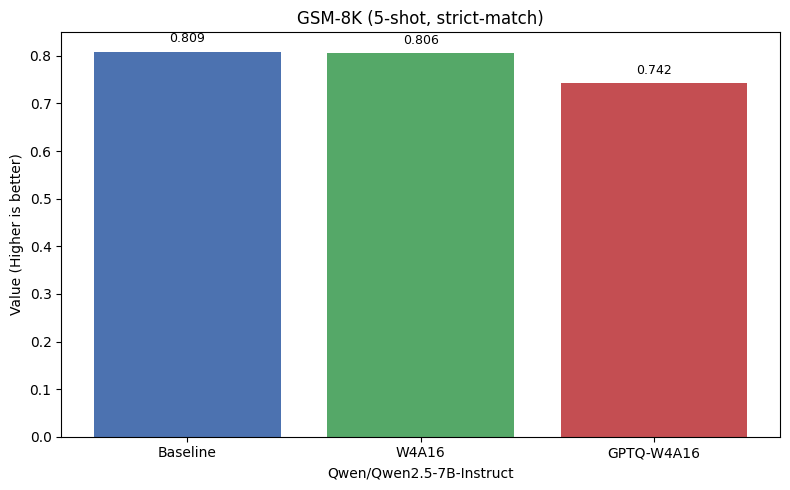

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Collect results into a list for easy iteration
results_list = [results_baseline, results_w4a16, results_gptq_w4a16]
model_names = ['Baseline', 'W4A16', 'GPTQ-W4A16']

# Extract the single metric
metric_key = "exact_match,strict-match"
values = [r["results"]["gsm8k"][metric_key] for r in results_list]

# Convert to numpy array
values = np.array(values)

# Plot settings
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, values, color=['#4c72b0', '#55a868', '#c44e52'])

# Labels and title
plt.ylabel("Value (Higher is better)")
plt.xlabel(model_id)
plt.title("GSM-8K (5-shot, strict-match)")

# Display values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [31]:
import pandas as pd

# Define model names
model_names = ['Baseline', 'W4A16', 'GPTQ-W4A16']

# Metrics we want to track
metrics = [
    ("exact_match,strict-match", "GSM-8K (5-shot, strict-match)"),    
]

# Extract values for each metric
results_list = [results_baseline, results_w4a16, results_gptq_w4a16]

# Prepare a dictionary to build the DataFrame
data = {"Model": model_names}

# For each metric, add the raw values and the recovery rates
for key, label in metrics:
    # Extract raw values
    values = [r["results"]["gsm8k"][key] for r in results_list]

    # Calculate recovery rate relative to baseline
    baseline = values[0]
    recovery = [
        100 if i == 0 else (v / baseline  * 100) for i, v in enumerate(values)
    ]
    
    # Add to table, placing recovery column right next to its metric
    data[label] = values
    data[f"Recovery (%)"] = recovery

# Create DataFrame
table = pd.DataFrame(data)

# Format nicely
pd.set_option('display.float_format', '{:.3f}'.format)
print(table.to_string(index=False))

     Model  GSM-8K (5-shot, strict-match)  Recovery (%)
  Baseline                          0.809       100.000
     W4A16                          0.806        99.625
GPTQ-W4A16                          0.742        91.753
